<a href="https://colab.research.google.com/github/hussien4/My-First-Project/blob/master/hourly_sum_load_block10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run the model for Block 10

In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

#For python users, you should also install pyspark using the following command.

!pip install pyspark

     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 198 kB 47.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=cae0272b82552a9f0f52c3e4f9b90246b327a06463f497b235b1f436dd6d0859
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [2]:
import findspark
findspark.init()

In [3]:
from google.colab import files
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import isnan, when, count, col, lit,to_date ,hour ,minute ,countDistinct
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
import pandas as pd 
import numpy as np 
import seaborn as sb 
%matplotlib inline
import matplotlib.pyplot as plt 

In [4]:
sc =SparkSession.builder.master("local").getOrCreate()

In [5]:
df1 = sc.read.csv('/content/drive/MyDrive/block_10.csv/Master/literature 2020/microgrid modeling/datasets/london smart meters with weather/halfhourly_dataset/block_10.csv' , inferSchema = True ,header = True)

In [6]:
df1 = df1.withColumnRenamed("energy(kWh/hh)","energy")

In [7]:
df1 = df1.withColumn("energy",df1["energy"].cast("float"))

In [8]:
df1 = df1.filter("energy > 0")

In [9]:
df1 = df1.na.drop()

In [10]:
df1 = df1.withColumn('date' ,to_date('tstp'))

In [11]:
df1 = df1.withColumn('hour' ,hour('tstp'))

In [12]:
df1 = df1.withColumn("minute", minute(col("tstp")))

In [13]:
df1 = df1.filter("minute == 0")

In [14]:
df1.show(1)

+---------+--------------------+------+----------+----+------+
|    LCLid|                tstp|energy|      date|hour|minute|
+---------+--------------------+------+----------+----+------+
|MAC000322|2012-03-06 14:00:...|  0.06|2012-03-06|  14|     0|
+---------+--------------------+------+----------+----+------+
only showing top 1 row



In [15]:
df1.dtypes

[('LCLid', 'string'),
 ('tstp', 'string'),
 ('energy', 'float'),
 ('date', 'date'),
 ('hour', 'int'),
 ('minute', 'int')]

In [16]:
df = pd.read_excel('/content/drive/MyDrive/Tariffs.xlsx')
df_tariff = sc.createDataFrame(df)
df_tariff.show(2)

+-------------------+------+
|     TariffDateTime|Tariff|
+-------------------+------+
|2013-01-01 00:00:00|Normal|
|2013-01-01 00:30:00|Normal|
+-------------------+------+
only showing top 2 rows



In [17]:
from pyspark.sql.functions import *
df1 = df1.withColumn('tstp0' ,to_timestamp('tstp'))

In [18]:
df_joined = df1.join(df_tariff , df1['tstp0']==df_tariff['TariffDateTime'] ,how ='left')

In [19]:
df_joined.show(2)

+---------+--------------------+------+----------+----+------+-------------------+--------------+------+
|    LCLid|                tstp|energy|      date|hour|minute|              tstp0|TariffDateTime|Tariff|
+---------+--------------------+------+----------+----+------+-------------------+--------------+------+
|MAC004959|2012-01-23 13:00:...| 0.652|2012-01-23|  13|     0|2012-01-23 13:00:00|          null|  null|
|MAC004959|2012-01-28 02:00:...|  0.21|2012-01-28|   2|     0|2012-01-28 02:00:00|          null|  null|
+---------+--------------------+------+----------+----+------+-------------------+--------------+------+
only showing top 2 rows



In [20]:
df_joined2  = df_joined.where((df_joined.Tariff.isNull()) | (df_joined.Tariff =='Normal'))

In [21]:
df1 = df_joined

In [22]:
df2 = df1.groupby(['hour','date']).sum()

In [23]:
columns = ['sum(hour)','sum(minute)']
for c in columns:
  df2 = df2.drop(c)

In [24]:
df2.show(1)

+----+----------+------------------+
|hour|      date|       sum(energy)|
+----+----------+------------------+
|  18|2012-12-10|24.674999862909317|
+----+----------+------------------+
only showing top 1 row



In [25]:
df_temp = df1.select(['date','LCLid','hour','Tariff','TariffDateTime'])

In [26]:

df_temp1 = df_temp.groupBy(["date",'hour','Tariff','TariffDateTime']).agg(countDistinct("LCLid"))

In [27]:
df_temp1.show(2)

+----------+----+------+-------------------+------------+
|      date|hour|Tariff|     TariffDateTime|count(LCLid)|
+----------+----+------+-------------------+------------+
|2013-08-04|   9|Normal|2013-08-04 09:00:00|          44|
|2013-05-24|  10|Normal|2013-05-24 10:00:00|          46|
+----------+----+------+-------------------+------------+
only showing top 2 rows



In [28]:
df_temp1 = df_temp1.withColumnRenamed('date','date1')
df_temp1 = df_temp1.withColumnRenamed('hour','hour1')

## Join two dataframes
 sothat we can see the number of houses per hour per date 

In [29]:
df22 = df2.join(df_temp1 , (df2['date']==df_temp1['date1']) & (df2['hour']==df_temp1['hour1']) , how = 'inner') 

In [30]:
df22.show(5)

+----+----------+------------------+----------+-----+------+-------------------+------------+
|hour|      date|       sum(energy)|     date1|hour1|Tariff|     TariffDateTime|count(LCLid)|
+----+----------+------------------+----------+-----+------+-------------------+------------+
|   0|2012-03-13| 1.953999973833561|2012-03-13|    0|  null|               null|          10|
|   0|2012-10-07| 8.006999982520938|2012-10-07|    0|  null|               null|          48|
|   0|2013-03-11| 16.19999986514449|2013-03-11|    0|Normal|2013-03-11 00:00:00|          46|
|   0|2013-03-13|13.637000050395727|2013-03-13|    0|Normal|2013-03-13 00:00:00|          46|
|   0|2013-05-13|   6.4940000558272|2013-05-13|    0|Normal|2013-05-13 00:00:00|          47|
+----+----------+------------------+----------+-----+------+-------------------+------------+
only showing top 5 rows



In [31]:
columns = ['date1' ,'hour1']
for c in columns:
  df1 = df22.drop(c)

In [32]:
df1.show(2)

+----+----------+-----------------+----------+------+--------------+------------+
|hour|      date|      sum(energy)|     date1|Tariff|TariffDateTime|count(LCLid)|
+----+----------+-----------------+----------+------+--------------+------------+
|   0|2012-03-13|1.953999973833561|2012-03-13|  null|          null|          10|
|   0|2012-10-07|8.006999982520938|2012-10-07|  null|          null|          48|
+----+----------+-----------------+----------+------+--------------+------------+
only showing top 2 rows



In [33]:
df1 = df1.drop("date1")
df1 = df1.withColumnRenamed("count(DISTINCT LCLid)" , "count_houses")

In [34]:
df1.show(10)

+----+----------+------------------+------+-------------------+------------+
|hour|      date|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|
+----+----------+------------------+------+-------------------+------------+
|   0|2012-03-13| 1.953999973833561|  null|               null|          10|
|   0|2012-10-07| 8.006999982520938|  null|               null|          48|
|   0|2013-03-11| 16.19999986514449|Normal|2013-03-11 00:00:00|          46|
|   0|2013-03-13|13.637000050395727|Normal|2013-03-13 00:00:00|          46|
|   0|2013-05-13|   6.4940000558272|Normal|2013-05-13 00:00:00|          47|
|   1|2013-04-19| 7.598000023514032|Normal|2013-04-19 01:00:00|          46|
|   1|2013-08-30| 6.488999990746379|Normal|2013-08-30 01:00:00|          45|
|   2|2012-03-30|1.6830000057816505|  null|               null|          15|
|   2|2012-07-27| 7.729000046849251|  null|               null|          49|
|   2|2013-10-11| 8.058999938890338|Normal|2013-10-11 02:00:00|          44|

In [35]:
df1.count()

18397

## Defining day and night column 

In [36]:
df_day = sc.read.csv('/content/drive/MyDrive/day_night.csv' , inferSchema = True ,header = True)

In [37]:
df_day = df_day.withColumn('date3' , to_date("date"))

In [38]:
df1 = df1.join(df_day , df1['date']==df_day['date3'], how ='inner'  )

In [39]:
columns = ['sum(hour)' ,'_c0' ,'date2' ]
for c in columns : 
  df1 = df1.drop(c)

In [40]:
df1 = df1.withColumn('hour_rise' ,hour('sunriseTime'))
df1 = df1.withColumn('hour_set' ,hour('sunsetTime'))

In [41]:
df1 = df1.withColumn('day_night'  ,\
                      when((col("hour") > col("hour_rise")) &( col("hour") < col("hour_set")),1)\
                      .when(  col("hour") < 6 ,0)\
                     .otherwise(2))

In [42]:
df1.show(20)

+----+----------+------------------+------+-------------------+------------+-------------------+-------------------+----------+----------+---------+--------+---------+
|hour|      date|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|        sunriseTime|         sunsetTime|      date|     date3|hour_rise|hour_set|day_night|
+----+----------+------------------+------+-------------------+------------+-------------------+-------------------+----------+----------+---------+--------+---------+
|   0|2012-03-13| 1.953999973833561|  null|               null|          10|2012-03-13 06:19:36|2012-03-13 18:02:47|2012-03-13|2012-03-13|        6|      18|        0|
|   0|2012-10-07| 8.006999982520938|  null|               null|          48|2012-10-08 06:14:19|2012-10-08 17:23:46|2012-10-07|2012-10-07|        6|      17|        0|
|   0|2013-03-11| 16.19999986514449|Normal|2013-03-11 00:00:00|          46|2013-03-11 06:24:44|2013-03-11 17:58:56|2013-03-11|2013-03-11|        6|      17|   

In [43]:
columns = ['sunriseTime','sunsetTime','hour_rise','hour_set']
for c in columns : 
  df1 = df1.drop(c)

In [44]:
df1.show(2)

+----+----------+-----------------+------+--------------+------------+----------+----------+---------+
|hour|      date|      sum(energy)|Tariff|TariffDateTime|count(LCLid)|      date|     date3|day_night|
+----+----------+-----------------+------+--------------+------------+----------+----------+---------+
|   0|2012-03-13|1.953999973833561|  null|          null|          10|2012-03-13|2012-03-13|        0|
|   0|2012-10-07|8.006999982520938|  null|          null|          48|2012-10-07|2012-10-07|        0|
+----+----------+-----------------+------+--------------+------------+----------+----------+---------+
only showing top 2 rows



## Add weather hourly

In [45]:
df_weather = sc.read.csv('/content/drive/MyDrive/weather_hourly_darksky.csv' , inferSchema = True ,header = True)

In [46]:
df_weather=df_weather.na.drop()

In [47]:
df_weather =df_weather.withColumn("date2" , to_date("time"))

In [48]:
df_weather =df_weather.withColumn("hour2" , hour("time"))

In [49]:
df_weather = df_weather.withColumnRenamed("time" , "time2")

In [50]:
df_temp =df1.join(df_weather , (df1['date3']==df_weather['date2']) & (df1['hour']==df_weather['hour2']), how ='inner')

In [51]:
df_temp.show(5)

+----+----------+------------------+------+-------------------+------------+----------+----------+---------+----------+-----------+-----------+-------------------+--------+--------+-------------------+---------+----------+-------------------+--------+-------------+----------+-----+
|hour|      date|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|      date|     date3|day_night|visibility|windBearing|temperature|              time2|dewPoint|pressure|apparentTemperature|windSpeed|precipType|               icon|humidity|      summary|     date2|hour2|
+----+----------+------------------+------+-------------------+------------+----------+----------+---------+----------+-----------+-----------+-------------------+--------+--------+-------------------+---------+----------+-------------------+--------+-------------+----------+-----+
|   0|2012-03-13| 1.953999973833561|  null|               null|          10|2012-03-13|2012-03-13|        0|      2.83|         62|       7.81|2012-03-

In [52]:
columns = ['windBearing','windSpeed','pressure'
            ,'precipType' , 'icon' ,'summary' , 
            'visibility' ,'dewPoint' ,'apparentTemperature' ,'date' ,'hour' ]
for c in columns : 
   df_temp =df_temp.drop(c)

In [53]:
df = df_temp

In [54]:
df.show(5)

+------------------+------+-------------------+------------+----------+---------+-----------+-------------------+--------+----------+-----+
|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|     date3|day_night|temperature|              time2|humidity|     date2|hour2|
+------------------+------+-------------------+------------+----------+---------+-----------+-------------------+--------+----------+-----+
| 1.953999973833561|  null|               null|          10|2012-03-13|        0|       7.81|2012-03-13 00:00:00|    0.92|2012-03-13|    0|
| 8.006999982520938|  null|               null|          48|2012-10-07|        0|       7.19|2012-10-07 00:00:00|    0.95|2012-10-07|    0|
| 16.19999986514449|Normal|2013-03-11 00:00:00|          46|2013-03-11|        0|       1.22|2013-03-11 00:00:00|    0.78|2013-03-11|    0|
|13.637000050395727|Normal|2013-03-13 00:00:00|          46|2013-03-13|        0|       2.32|2013-03-13 00:00:00|    0.84|2013-03-13|    0|
|   6.4940000558272|

## Add bank holidays 

In [55]:
df_holi = sc.read.csv('/content/drive/MyDrive/uk_bank_holidays.csv',header=True,inferSchema=True)

In [56]:
df_holi = df_holi.withColumn('date4' ,to_date('Bank holidays'))

In [57]:
df_temp = df.join(df_holi ,df['date3']==df_holi['date4'] , how ='outer')

In [58]:
df_temp = df_temp.withColumn('week_end',when(df_temp['date2']==df_temp['date4'],1).otherwise(0))

In [59]:
from pyspark.sql.functions import date_trunc
from pyspark.sql.functions import to_date ,hour
from pyspark.sql.functions import isnan, when, count, col, lit
from pyspark.sql.functions import date_format
df_temp = df_temp.withColumn("week_day", date_format(col("time2"), "E"))

In [60]:
df_temp = df_temp\
.withColumn("week_end", when(col("week_day") == "Sat",1)\
            .when(col("week_day") =="Sun",1).otherwise(0))

In [61]:
df_temp.show(5)

+------------------+------+--------------+------------+----------+---------+-----------+-------------------+--------+----------+-----+-------------+----+-----+--------+--------+
|       sum(energy)|Tariff|TariffDateTime|count(LCLid)|     date3|day_night|temperature|              time2|humidity|     date2|hour2|Bank holidays|Type|date4|week_end|week_day|
+------------------+------+--------------+------------+----------+---------+-----------+-------------------+--------+----------+-----+-------------+----+-----+--------+--------+
| 2.441000036895275|  null|          null|          16|2012-04-17|        1|      13.77|2012-04-17 14:00:00|    0.42|2012-04-17|   14|         null|null| null|       0|     Tue|
|2.6650000158697367|  null|          null|          16|2012-04-17|        1|      10.96|2012-04-17 11:00:00|    0.75|2012-04-17|   11|         null|null| null|       0|     Tue|
| 6.160000003874302|  null|          null|          16|2012-04-17|        2|       6.41|2012-04-17 20:00:00|  

In [62]:
columns= ['time2','date2','date3','sum(hour)','time','date2','Bank holidays','Type','date4','week_day']
for c in columns:
  df_temp = df_temp.drop(c)

In [63]:
df_temp.show(5)

+------------------+------+--------------+------------+---------+-----------+--------+-----+--------+
|       sum(energy)|Tariff|TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|
+------------------+------+--------------+------------+---------+-----------+--------+-----+--------+
| 2.441000036895275|  null|          null|          16|        1|      13.77|    0.42|   14|       0|
|2.6650000158697367|  null|          null|          16|        1|      10.96|    0.75|   11|       0|
| 6.160000003874302|  null|          null|          16|        2|       6.41|    0.81|   20|       0|
|  4.70799995213747|  null|          null|          16|        1|       9.16|    0.75|   16|       0|
| 6.481999985873699|  null|          null|          16|        1|       8.82|    0.72|   18|       0|
+------------------+------+--------------+------------+---------+-----------+--------+-----+--------+
only showing top 5 rows



In [64]:
df= df_temp

In [65]:
df.show(2)

+------------------+------+--------------+------------+---------+-----------+--------+-----+--------+
|       sum(energy)|Tariff|TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|
+------------------+------+--------------+------------+---------+-----------+--------+-----+--------+
| 2.441000036895275|  null|          null|          16|        1|      13.77|    0.42|   14|       0|
|2.6650000158697367|  null|          null|          16|        1|      10.96|    0.75|   11|       0|
+------------------+------+--------------+------------+---------+-----------+--------+-----+--------+
only showing top 2 rows



In [66]:
## start to separate low , normal and null , high tariffs each in a separate dataset : 
## low 
df_low_tariff = df.filter("Tariff = 'Low'")

In [67]:
# high 
df_high_tariff = df.filter("Tariff = 'High'")

In [68]:
# normal
# df_joined2  = df_joined.where((df_joined.Tariff.isNull()) | (df_joined.Tariff =='Normal'))
df = df.where((df.Tariff.isNull()) | (df.Tariff =='Normal'))

In [69]:
df.show(2)

+------------------+------+--------------+------------+---------+-----------+--------+-----+--------+
|       sum(energy)|Tariff|TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|
+------------------+------+--------------+------------+---------+-----------+--------+-----+--------+
| 2.441000036895275|  null|          null|          16|        1|      13.77|    0.42|   14|       0|
|2.6650000158697367|  null|          null|          16|        1|      10.96|    0.75|   11|       0|
+------------------+------+--------------+------------+---------+-----------+--------+-----+--------+
only showing top 2 rows



In [70]:
columns = ['Tariff','TariffDateTime']
for c in columns: 
  df = df.drop(c)

In [71]:
df.show(2)

+------------------+------------+---------+-----------+--------+-----+--------+
|       sum(energy)|count(LCLid)|day_night|temperature|humidity|hour2|week_end|
+------------------+------------+---------+-----------+--------+-----+--------+
| 2.441000036895275|          16|        1|      13.77|    0.42|   14|       0|
|2.6650000158697367|          16|        1|      10.96|    0.75|   11|       0|
+------------------+------------+---------+-----------+--------+-----+--------+
only showing top 2 rows



In [72]:
df.count()

17168

In [73]:
df  =df.na.drop()

In [74]:
df.count()

17161

In [75]:
from pyspark.ml.feature import OneHotEncoder
stages = []
column_list = ['hour2' ,'week_end','day_night']
for column in column_list :
  encoder = OneHotEncoder(inputCol=column, outputCol=column+"_encoded")
  stages.append(encoder)
pipeline = Pipeline(stages = stages )
df_encoded = pipeline.fit(df).transform(df)  

In [76]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
vector_assembler = VectorAssembler(inputCols = ['hour2_encoded','temperature' ,'humidity','week_end_encoded','day_night_encoded','count(LCLid)'] 
                                   ,outputCol = 'features_vector')
df = vector_assembler.transform(df_encoded)
df.show(3)

+-----------------+------------+---------+-----------+--------+-----+--------+--------------+----------------+-----------------+--------------------+
|      sum(energy)|count(LCLid)|day_night|temperature|humidity|hour2|week_end| hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|
+-----------------+------------+---------+-----------+--------+-----+--------+--------------+----------------+-----------------+--------------------+
|1.953999973833561|          10|        0|       7.81|    0.92|    0|       0|(23,[0],[1.0])|   (1,[0],[1.0])|    (2,[0],[1.0])|(29,[0,23,24,25,2...|
|8.006999982520938|          48|        0|       7.19|    0.95|    0|       1|(23,[0],[1.0])|       (1,[],[])|    (2,[0],[1.0])|(29,[0,23,24,26,2...|
|16.19999986514449|          46|        0|       1.22|    0.78|    0|       0|(23,[0],[1.0])|   (1,[0],[1.0])|    (2,[0],[1.0])|(29,[0,23,24,25,2...|
+-----------------+------------+---------+-----------+--------+-----+--------+--------------+-------

In [77]:
df.count()

17161

In [78]:
from pyspark.ml import Pipeline
# expansion parameters 
from pyspark.ml.feature import PolynomialExpansion
poly = PolynomialExpansion(inputCol='features_vector', outputCol='poly_features')
df = poly.transform(df)

In [79]:
ss = StandardScaler(withMean=True, withStd=True, inputCol='poly_features' , outputCol='poly_features_scaled')

In [80]:
df =ss.fit(df).transform(df)

In [81]:
df.show(2)

+-----------------+------------+---------+-----------+--------+-----+--------+--------------+----------------+-----------------+--------------------+--------------------+--------------------+
|      sum(energy)|count(LCLid)|day_night|temperature|humidity|hour2|week_end| hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|       poly_features|poly_features_scaled|
+-----------------+------------+---------+-----------+--------+-----+--------+--------------+----------------+-----------------+--------------------+--------------------+--------------------+
|1.953999973833561|          10|        0|       7.81|    0.92|    0|       0|(23,[0],[1.0])|   (1,[0],[1.0])|    (2,[0],[1.0])|(29,[0,23,24,25,2...|(464,[0,1,299,300...|[4.79234167381561...|
|8.006999982520938|          48|        0|       7.19|    0.95|    0|       1|(23,[0],[1.0])|       (1,[],[])|    (2,[0],[1.0])|(29,[0,23,24,26,2...|(464,[0,1,299,300...|[4.79234167381561...|
+-----------------+------------+--------

In [82]:
df_train,df_test = df.randomSplit([0.8,0.2])

In [83]:
df_train.show(2)

+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+
|        sum(energy)|count(LCLid)|day_night|temperature|humidity|hour2|week_end|  hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|       poly_features|poly_features_scaled|
+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+
|0.24300000071525574|           1|        1|       5.78|     0.8|   13|       1|(23,[13],[1.0])|       (1,[],[])|    (2,[1],[1.0])|(29,[13,23,24,27,...|(464,[104,118,299...|[-0.2086540978079...|
| 1.6830000057816505|          15|        0|       9.29|    0.76|    2|       0| (23,[2],[1.0])|   (1,[0],[1.0])|    (2,[0],[1.0])|(29,[2,23,24,25,2...|(464,[5,8,299,302...|[-0.2086540978079...|
+-------------------+----

In [84]:
dropped_col = ['count(LCLid)','day_night','temperature','humidity','week_end','hour2_encoded','week_end_encoded','day_night_encoded','hour2','features_vector','poly_features']
for c in dropped_col:
  df_train = df_train.drop(c)
df_train.show(2)  

+-------------------+--------------------+
|        sum(energy)|poly_features_scaled|
+-------------------+--------------------+
|0.24300000071525574|[-0.2086540978079...|
| 1.6830000057816505|[-0.2086540978079...|
+-------------------+--------------------+
only showing top 2 rows



### Plain MLR 

In [85]:
from pyspark.ml.regression import LinearRegression
# elasticnetparam = 0 --> ridge regression (L2 penalty )
lr =LinearRegression( featuresCol='poly_features_scaled', labelCol='sum(energy)',elasticNetParam=0)

In [ ]:
pipeline = Pipeline(stages = [lr])

In [ ]:
pipeline.write().overwrite().save("pipeline")
pipelineModel = Pipeline.load("pipeline")

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
paramGrid =  ParamGridBuilder().build()

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='sum(energy)', metricName='r2')

In [ ]:
crossval = CrossValidator(estimator=pipelineModel,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2 ,collectSubModels=True)

In [ ]:
cvmodel = crossval.fit(df_train)

In [ ]:
cvmodel.avgMetrics

[0.9018560358586698]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

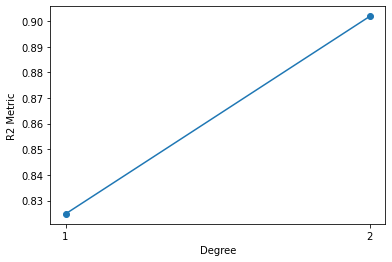

In [ ]:
#degree =[1,2]
import pandas as pd 
import numpy as np 
import seaborn as sb 
%matplotlib inline
import matplotlib.pyplot as plt 
#plt.xscale('log')
plt.xlabel("Degree" ,fontsize = 10 )
plt.ylabel("R2 Metric" ,fontsize = 10 )
plt.xticks(ticks = [1,2,3],fontsize = 10 ,fontweight= 500 )
plt.yticks(fontsize = 10,fontweight= 500) 
#ax = figure.add_subplot(111)
plt.plot(degree ,cvmodel.avgMetrics , '-o')
from google.colab import files
plt.savefig("Plain MLR.png")
files.download("Plain MLR.png")

#### Testing Plain MLR 

In [ ]:
pred = cvmodel.transform(df_test)

In [ ]:
eval =RegressionEvaluator(labelCol="sum(energy)")
r2 = eval.evaluate(pred,{eval.metricName:"r2"})

In [ ]:
r2

0.8946444091488525

### Lasso Regression 

In [86]:
from pyspark.ml.regression import LinearRegression
# elasticnetparam = 0 --> ridge regression (L2 penalty )
lr =LinearRegression( featuresCol='poly_features_scaled', labelCol='sum(energy)',elasticNetParam=1)

In [87]:
pipeline = Pipeline(stages = [lr])

In [88]:
pipeline.write().overwrite().save("pipeline")
pipelineModel = Pipeline.load("pipeline")

In [89]:
# elasticNetParam = Param(parent='undefined', name='elasticNetParam', 
#doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, 
#the penalty is an L2 penalty (ridge). For alpha = 1, it is an L1 penalty. (lasso)')
from pyspark.ml.tuning import ParamGridBuilder
paramGrid =  ParamGridBuilder().addGrid(lr.regParam, [1,0.1,0.01,0.001,0.0001,0.00001]).build()

In [90]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='sum(energy)', metricName='r2')

In [91]:
crossval = CrossValidator(estimator=pipelineModel,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2 ,collectSubModels=True)

In [92]:
cvmodel = crossval.fit(df_train)

In [93]:
cvmodel.avgMetrics

[0.583878474644168,
 0.8664282285212588,
 0.899893108237451,
 0.9012214276325328,
 0.9007723335368519,
 0.9007513225388246]

In [94]:
alphas = [1,0.1,0.01,0.001,0.0001,0.00001]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

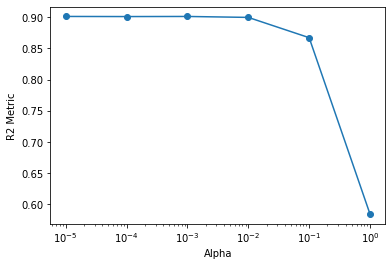

In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sb 
%matplotlib inline
import matplotlib.pyplot as plt 
plt.xscale('log')
plt.xlabel("Alpha" ,fontsize = 10 )
plt.ylabel("R2 Metric" ,fontsize = 10 )
plt.xticks(fontsize = 10 ,fontweight= 500 )
plt.yticks(fontsize = 10,fontweight= 500) 
#ax = figure.add_subplot(111)
plt.plot(alphas ,cvmodel.avgMetrics , '-o')
from google.colab import files
plt.savefig("Lasso.png")
files.download("Lasso.png")

#### Testing Lasso Model 

In [ ]:
pred = cvmodel.transform(df_test)

In [ ]:
eval =RegressionEvaluator(labelCol="sum(energy)")
r2 = eval.evaluate(pred,{eval.metricName:"r2"})
r2

0.8990028555882429

### Ridge Regression 

In [ ]:
from pyspark.ml.regression import LinearRegression
# elasticnetparam = 0 --> ridge regression (L2 penalty )
lr =LinearRegression( featuresCol='poly_features_scaled', labelCol='sum(energy)',elasticNetParam=0.0)

In [ ]:
pipeline = Pipeline(stages = [lr])

In [ ]:
pipeline.write().overwrite().save("pipeline")
pipelineModel = Pipeline.load("pipeline")

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='sum(energy)', metricName='r2')

In [ ]:
# elasticNetParam = Param(parent='undefined', name='elasticNetParam', 
#doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, 
#the penalty is an L2 penalty (ridge). For alpha = 1, it is an L1 penalty. (lasso)')
from pyspark.ml.tuning import ParamGridBuilder
paramGrid =  ParamGridBuilder().addGrid(poly.degree,[2]).addGrid(lr.regParam, [1,0.1,0.01,0.001,0.0001,0.00001]).build()

In [ ]:
crossval = CrossValidator(estimator=pipelineModel,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2 ,collectSubModels=True)

In [ ]:
## fit model 
cvmodel = crossval.fit(df_train)

In [ ]:
type(cvmodel)

pyspark.ml.tuning.CrossValidatorModel

In [ ]:
best_model = cvmodel.bestModel

In [ ]:
cvmodel.avgMetrics

[0.8694204246525716,
 0.8980329983553721,
 0.9016963401652787,
 0.9021193464731789,
 0.902137662955178,
 0.9021372722043419]

In [ ]:
alphas = [1,0.1,0.01,0.001,0.0001,0.00001]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

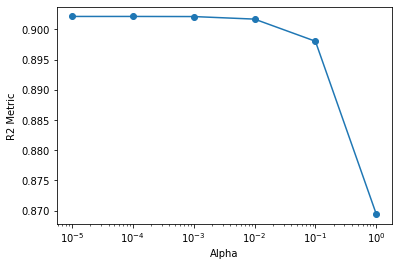

In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sb 
%matplotlib inline
import matplotlib.pyplot as plt 
plt.xscale('log')
plt.xlabel("Alpha" ,fontsize = 10 )
plt.ylabel("R2 Metric" ,fontsize = 10 )
plt.xticks(fontsize = 10 ,fontweight= 500 )
plt.yticks(fontsize = 10,fontweight= 500) 
#ax = figure.add_subplot(111)
plt.plot(alphas ,cvmodel.avgMetrics , '-o')
from google.colab import files
plt.savefig("ridge.png")
files.download("ridge.png") 

In [ ]:
print(cvmodel.getEstimatorParamMaps()[np.argmax(cvmodel.avgMetrics)])

{Param(parent='PolynomialExpansion_306277c03bd3', name='degree', doc='the polynomial degree to expand (>= 1)'): 2, Param(parent='LinearRegression_0b0cce662a9b', name='regParam', doc='regularization parameter (>= 0).'): 1e-05}


## Evaluating dToU for Low Tariff:  

In [95]:
df_low_tariff = df_low_tariff.na.drop()

In [96]:
df_low_tariff.show(2)

+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+
|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+
| 8.244000058621168|   Low|2013-02-21 03:00:00|          46|        0|       1.29|    0.63|    3|       0|
|12.416999971028417|   Low|2013-09-13 13:00:00|          44|        1|      17.16|    0.92|   13|       0|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+
only showing top 2 rows



In [97]:
df_low_tariff.count()

829

In [98]:
from pyspark.ml.feature import OneHotEncoder
stages = []
column_list = ['hour2' ,'week_end','day_night']
for column in column_list :
  encoder = OneHotEncoder(inputCol=column, outputCol=column+"_encoded")
  stages.append(encoder)
pipeline = Pipeline(stages = stages )
df_encoded_low_tariff = pipeline.fit(df_low_tariff).transform(df_low_tariff)  

In [99]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
vector_assembler = VectorAssembler(inputCols = ['hour2_encoded','temperature' ,'humidity','week_end_encoded','day_night_encoded','count(LCLid)'] 
                                   ,outputCol = 'features_vector')
df_encoded_low_tariff = vector_assembler.transform(df_encoded_low_tariff)
df_encoded_low_tariff.show(3)

+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+
|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|  hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+
| 8.244000058621168|   Low|2013-02-21 03:00:00|          46|        0|       1.29|    0.63|    3|       0| (23,[3],[1.0])|   (1,[0],[1.0])|    (2,[0],[1.0])|(29,[3,23,24,25,2...|
|12.416999971028417|   Low|2013-09-13 13:00:00|          44|        1|      17.16|    0.92|   13|       0|(23,[13],[1.0])|   (1,[0],[1.0])|    (2,[1],[1.0])|(29,[13,23,24,25,...|
|11.878000056371093|   Low|2013-11-26 15:00:00|          44|        1|       7.23|    0.64|   15|       0

In [100]:
from pyspark.ml import Pipeline
# expansion parameters 
from pyspark.ml.feature import PolynomialExpansion
poly = PolynomialExpansion(inputCol='features_vector', outputCol='poly_features')
df_encoded_low_tariff = poly.transform(df_encoded_low_tariff)

In [101]:
ss = StandardScaler(withMean=True, withStd=True, inputCol='poly_features' , outputCol='poly_features_scaled')

In [102]:
df_encoded_low_tariff = ss.fit(df_encoded_low_tariff).transform(df_encoded_low_tariff)

In [103]:
df_encoded_low_tariff.show(2)

+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+
|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|  hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|       poly_features|poly_features_scaled|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+
| 8.244000058621168|   Low|2013-02-21 03:00:00|          46|        0|       1.29|    0.63|    3|       0| (23,[3],[1.0])|   (1,[0],[1.0])|    (2,[0],[1.0])|(29,[3,23,24,25,2...|(464,[9,13,299,30...|[-0.2220530081768...|
|12.416999971028417|   Low|2013-09-13 13:00:00|          44|        1|      17.16|    0.92|   13|       0|(23,[13],[

In [104]:
df_test.show(2)

+-----------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+
|      sum(energy)|count(LCLid)|day_night|temperature|humidity|hour2|week_end|  hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|       poly_features|poly_features_scaled|
+-----------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+
|6.488999990746379|          45|        0|      16.34|    0.59|    1|       0| (23,[1],[1.0])|   (1,[0],[1.0])|    (2,[0],[1.0])|(29,[1,23,24,25,2...|(464,[2,4,299,301...|[-0.2086540978079...|
|7.723999971523881|          44|        1|      11.97|    0.93|   10|       1|(23,[10],[1.0])|       (1,[],[])|    (2,[1],[1.0])|(29,[10,23,24,27,...|(464,[65,76,299,3...|[-0.2086540978079...|
+-----------------+------------+---

In [105]:
predictions_low = cvmodel.transform(df_encoded_low_tariff)

In [106]:
# r2 
eval =RegressionEvaluator(labelCol="sum(energy)")
r2 = eval.evaluate(predictions_low,{eval.metricName:"r2"})
r2

0.07517035092743174

In [107]:
predictions_low.show(2)

+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+------------------+
|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|  hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|       poly_features|poly_features_scaled|        prediction|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+------------------+
| 8.244000058621168|   Low|2013-02-21 03:00:00|          46|        0|       1.29|    0.63|    3|       0| (23,[3],[1.0])|   (1,[0],[1.0])|    (2,[0],[1.0])|(29,[3,23,24,25,2...|(464,[9,13,299,30...|[-0.2220530081768...|10.249433793194708|
|12.416999971028417|   Low|2013-09-13 13

In [108]:
predictions_low_pandas= predictions_low.toPandas()

In [109]:
predictions_low_pandas.to_csv("/content/drive/MyDrive/predictions_low.csv")

## Evaluating dToU for High Tariff:  

In [110]:
df_high_tariff = df_high_tariff.na.drop()

In [111]:
df_high_tariff.count()

394

In [112]:
df_high_tariff.show(2)

+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+
|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+
|13.790999963879585|  High|2013-06-17 11:00:00|          45|        1|      17.54|    0.61|   11|       0|
|23.072999991476536|  High|2013-12-15 20:00:00|          44|        2|      12.42|    0.91|   20|       1|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+
only showing top 2 rows



In [113]:
from pyspark.ml.feature import OneHotEncoder
stages = []
column_list = ['hour2' ,'week_end','day_night']
for column in column_list :
  encoder = OneHotEncoder(inputCol=column, outputCol=column+"_encoded")
  stages.append(encoder)
pipeline = Pipeline(stages = stages )
df_encoded_high_tariff = pipeline.fit(df_high_tariff).transform(df_high_tariff) 

In [114]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
vector_assembler = VectorAssembler(inputCols = ['hour2_encoded','temperature' ,'humidity','week_end_encoded','day_night_encoded','count(LCLid)'] 
                                   ,outputCol = 'features_vector')
df_encoded_high_tariff = vector_assembler.transform(df_encoded_high_tariff)
df_encoded_high_tariff.show(3)

+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+
|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|  hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+
|13.790999963879585|  High|2013-06-17 11:00:00|          45|        1|      17.54|    0.61|   11|       0|(23,[11],[1.0])|   (1,[0],[1.0])|    (2,[1],[1.0])|(29,[11,23,24,25,...|
|23.072999991476536|  High|2013-12-15 20:00:00|          44|        2|      12.42|    0.91|   20|       1|(23,[20],[1.0])|       (1,[],[])|        (2,[],[])|(29,[20,23,24,28]...|
|18.111000057309866|  High|2013-12-27 22:00:00|          43|        2|       7.47|    0.73|   22|       0

In [115]:
from pyspark.ml import Pipeline
# expansion parameters 
from pyspark.ml.feature import PolynomialExpansion
poly = PolynomialExpansion(inputCol='features_vector', outputCol='poly_features')
df_encoded_high_tariff = poly.transform(df_encoded_high_tariff)

In [116]:
ss = StandardScaler(withMean=True, withStd=True, inputCol='poly_features' , outputCol='poly_features_scaled')

In [117]:
df_encoded_high_tariff = ss.fit(df_encoded_high_tariff).transform(df_encoded_high_tariff)

In [118]:
df_encoded_high_tariff.show(2)

+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+
|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|  hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|       poly_features|poly_features_scaled|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+
|13.790999963879585|  High|2013-06-17 11:00:00|          45|        1|      17.54|    0.61|   11|       0|(23,[11],[1.0])|   (1,[0],[1.0])|    (2,[1],[1.0])|(29,[11,23,24,25,...|(464,[77,89,299,3...|[-0.1527000060419...|
|23.072999991476536|  High|2013-12-15 20:00:00|          44|        2|      12.42|    0.91|   20|       1|(23,[20],[

In [119]:
predictions_high = cvmodel.transform(df_encoded_high_tariff)

In [120]:
# r2 
eval =RegressionEvaluator(labelCol="sum(energy)")
r2 = eval.evaluate(predictions_high,{eval.metricName:"r2"})
r2

-0.03675988849942935

In [121]:
predictions_high.show(2)

+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+-----------------+
|       sum(energy)|Tariff|     TariffDateTime|count(LCLid)|day_night|temperature|humidity|hour2|week_end|  hour2_encoded|week_end_encoded|day_night_encoded|     features_vector|       poly_features|poly_features_scaled|       prediction|
+------------------+------+-------------------+------------+---------+-----------+--------+-----+--------+---------------+----------------+-----------------+--------------------+--------------------+--------------------+-----------------+
|13.790999963879585|  High|2013-06-17 11:00:00|          45|        1|      17.54|    0.61|   11|       0|(23,[11],[1.0])|   (1,[0],[1.0])|    (2,[1],[1.0])|(29,[11,23,24,25,...|(464,[77,89,299,3...|[-0.1527000060419...| 6.69108820880484|
|23.072999991476536|  High|2013-12-15 20:00:

In [122]:
predictions_high_pandas= predictions_high.toPandas()

In [123]:
predictions_high_pandas.to_csv("/content/drive/MyDrive/predictions_high.csv")